# EmployeePayHistory

## Import the necessary libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [27]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading in the data

In [28]:
sql_query_employeepayhistory = "SELECT * FROM EmployeePayHistory"
employeepayhistory_df = read_data_return_df(sql_query_employeepayhistory, engine)

employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_sk,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,EMPLOYEEPAYHISTORY_datetime_added
0,1,508,2009-01-14,125.5000,2,2024-05-25 08:07:45.660
1,2,659,2008-01-31,63.4615,2,2024-05-25 08:07:45.660
2,3,890,2007-11-11,43.2692,2,2024-05-25 08:07:45.660
3,4,660,2007-12-05,8.6200,2,2024-05-25 08:07:45.660
4,5,660,2010-05-31,23.7200,2,2024-05-25 08:07:45.660


In [29]:
sql_query_businessentity = "SELECT * FROM BusinessEntity"
businessentity_df = read_data_return_df(sql_query_businessentity, engine)

businessentity_df.head()

,BUSINESSENTITY_sk,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID,BUSINESSENTITY_CONTACTTYPE_Name,BUSINESSENTITY_datetime_added
0,1,NaN,NaN,1.0,Accounting Manager,2024-05-25 08:06:16.757
1,2,1510.0,1509.0,2.0,Assistant Sales Agent,2024-05-25 08:06:16.757
2,3,1518.0,1517.0,2.0,Assistant Sales Agent,2024-05-25 08:06:16.757
3,4,1522.0,1521.0,2.0,Assistant Sales Agent,2024-05-25 08:06:16.757
4,5,1528.0,1527.0,2.0,Assistant Sales Agent,2024-05-25 08:06:16.757


In [30]:
sql_query_employee = "SELECT EMPLOYEE_EMPLOYEE_EmployeeID, EMPLOYEE_EMPLOYEE_BirthDate, EMPLOYEE_EMPLOYEE_ManagerID, EMPLOYEE_EMPLOYEE_DeptID, EMPLOYEE_EMPLOYEE_State, EMPLOYEE_EMPLOYEE_Start_Date FROM Employee"
employee_df = read_data_return_df(sql_query_employee, engine)

employee_df.head()

,EMPLOYEE_EMPLOYEE_EmployeeID,EMPLOYEE_EMPLOYEE_BirthDate,EMPLOYEE_EMPLOYEE_ManagerID,EMPLOYEE_EMPLOYEE_DeptID,EMPLOYEE_EMPLOYEE_State,EMPLOYEE_EMPLOYEE_Start_Date
0,1,1969-01-29,NaN,NaN,None,None
1,2,1971-08-01,NaN,NaN,None,None
2,3,1974-11-12,NaN,NaN,None,None
3,4,1974-12-23,NaN,NaN,None,None
4,5,1952-09-27,NaN,NaN,None,None


## Data Cleaning

In [31]:
# combining the dataframes
combined_df = pd.merge(employeepayhistory_df ,businessentity_df, left_on='EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', right_on='BUSINESSENTITY_sk', suffixes=('_eph', '_b'))

combined_df = pd.merge(combined_df, employee_df, left_on='BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID', right_on='EMPLOYEE_EMPLOYEE_EmployeeID', suffixes=('', '_e'), how='outer')

# dropping the datetime_added and sk columns
drop_columns(combined_df)

In [32]:
# dropping unnecessary columns
columns_to_keep = ['EMPLOYEE_EMPLOYEE_EmployeeID', 'EMPLOYEE_EMPLOYEE_ManagerID', 'EMPLOYEE_EMPLOYEE_DeptID', 'EMPLOYEE_EMPLOYEE_State',  'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency', 'BUSINESSENTITY_CONTACTTYPE_ContactTypeID', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate', 'EMPLOYEE_EMPLOYEE_BirthDate', 'EMPLOYEE_EMPLOYEE_Start_Date']

combined_df = combined_df[columns_to_keep]

In [33]:
# converting EMPLOYEE_EMPLOYEE_State
combined_df['EMPLOYEE_EMPLOYEE_State'] = combined_df['EMPLOYEE_EMPLOYEE_State'].astype('category').cat.codes

# Ensure the date column is in datetime format
combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = pd.to_datetime(combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'])
combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] = pd.to_datetime(combined_df['EMPLOYEE_EMPLOYEE_BirthDate'])
combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] = pd.to_datetime(combined_df['EMPLOYEE_EMPLOYEE_Start_Date'])

# Convert the datetime column to number of days since Unix epoch
combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = (combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] = (combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] = (combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

ValueError: time data "-1" doesn't match format "%Y-%m-%d", at position 328. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
combined_df

## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [ ]:
# splitting the data
X = combined_df.drop(columns=['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'])
y = combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [34]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [36]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [37]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 271.1930174760495
R2 Score: -1.071891158615006


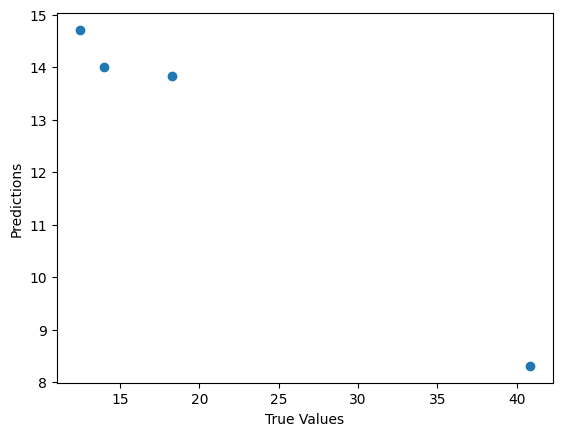

In [38]:
# visualizing the results
plt.scatter(y_test, lr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [39]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,40.8654,8.307272,3.255813e+01,3.255813e+01,1.060032e+03
1,12.4500,14.709799,-2.259799e+00,2.259799e+00,5.106692e+00
5,14.0000,14.000000,-3.552714e-15,3.552714e-15,1.262177e-29
14,18.2692,13.838212,4.430988e+00,4.430988e+00,1.963366e+01


### Decision Tree Regressor

In [40]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [41]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [42]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 254.07602145
R2 Score: -0.9411187919129311


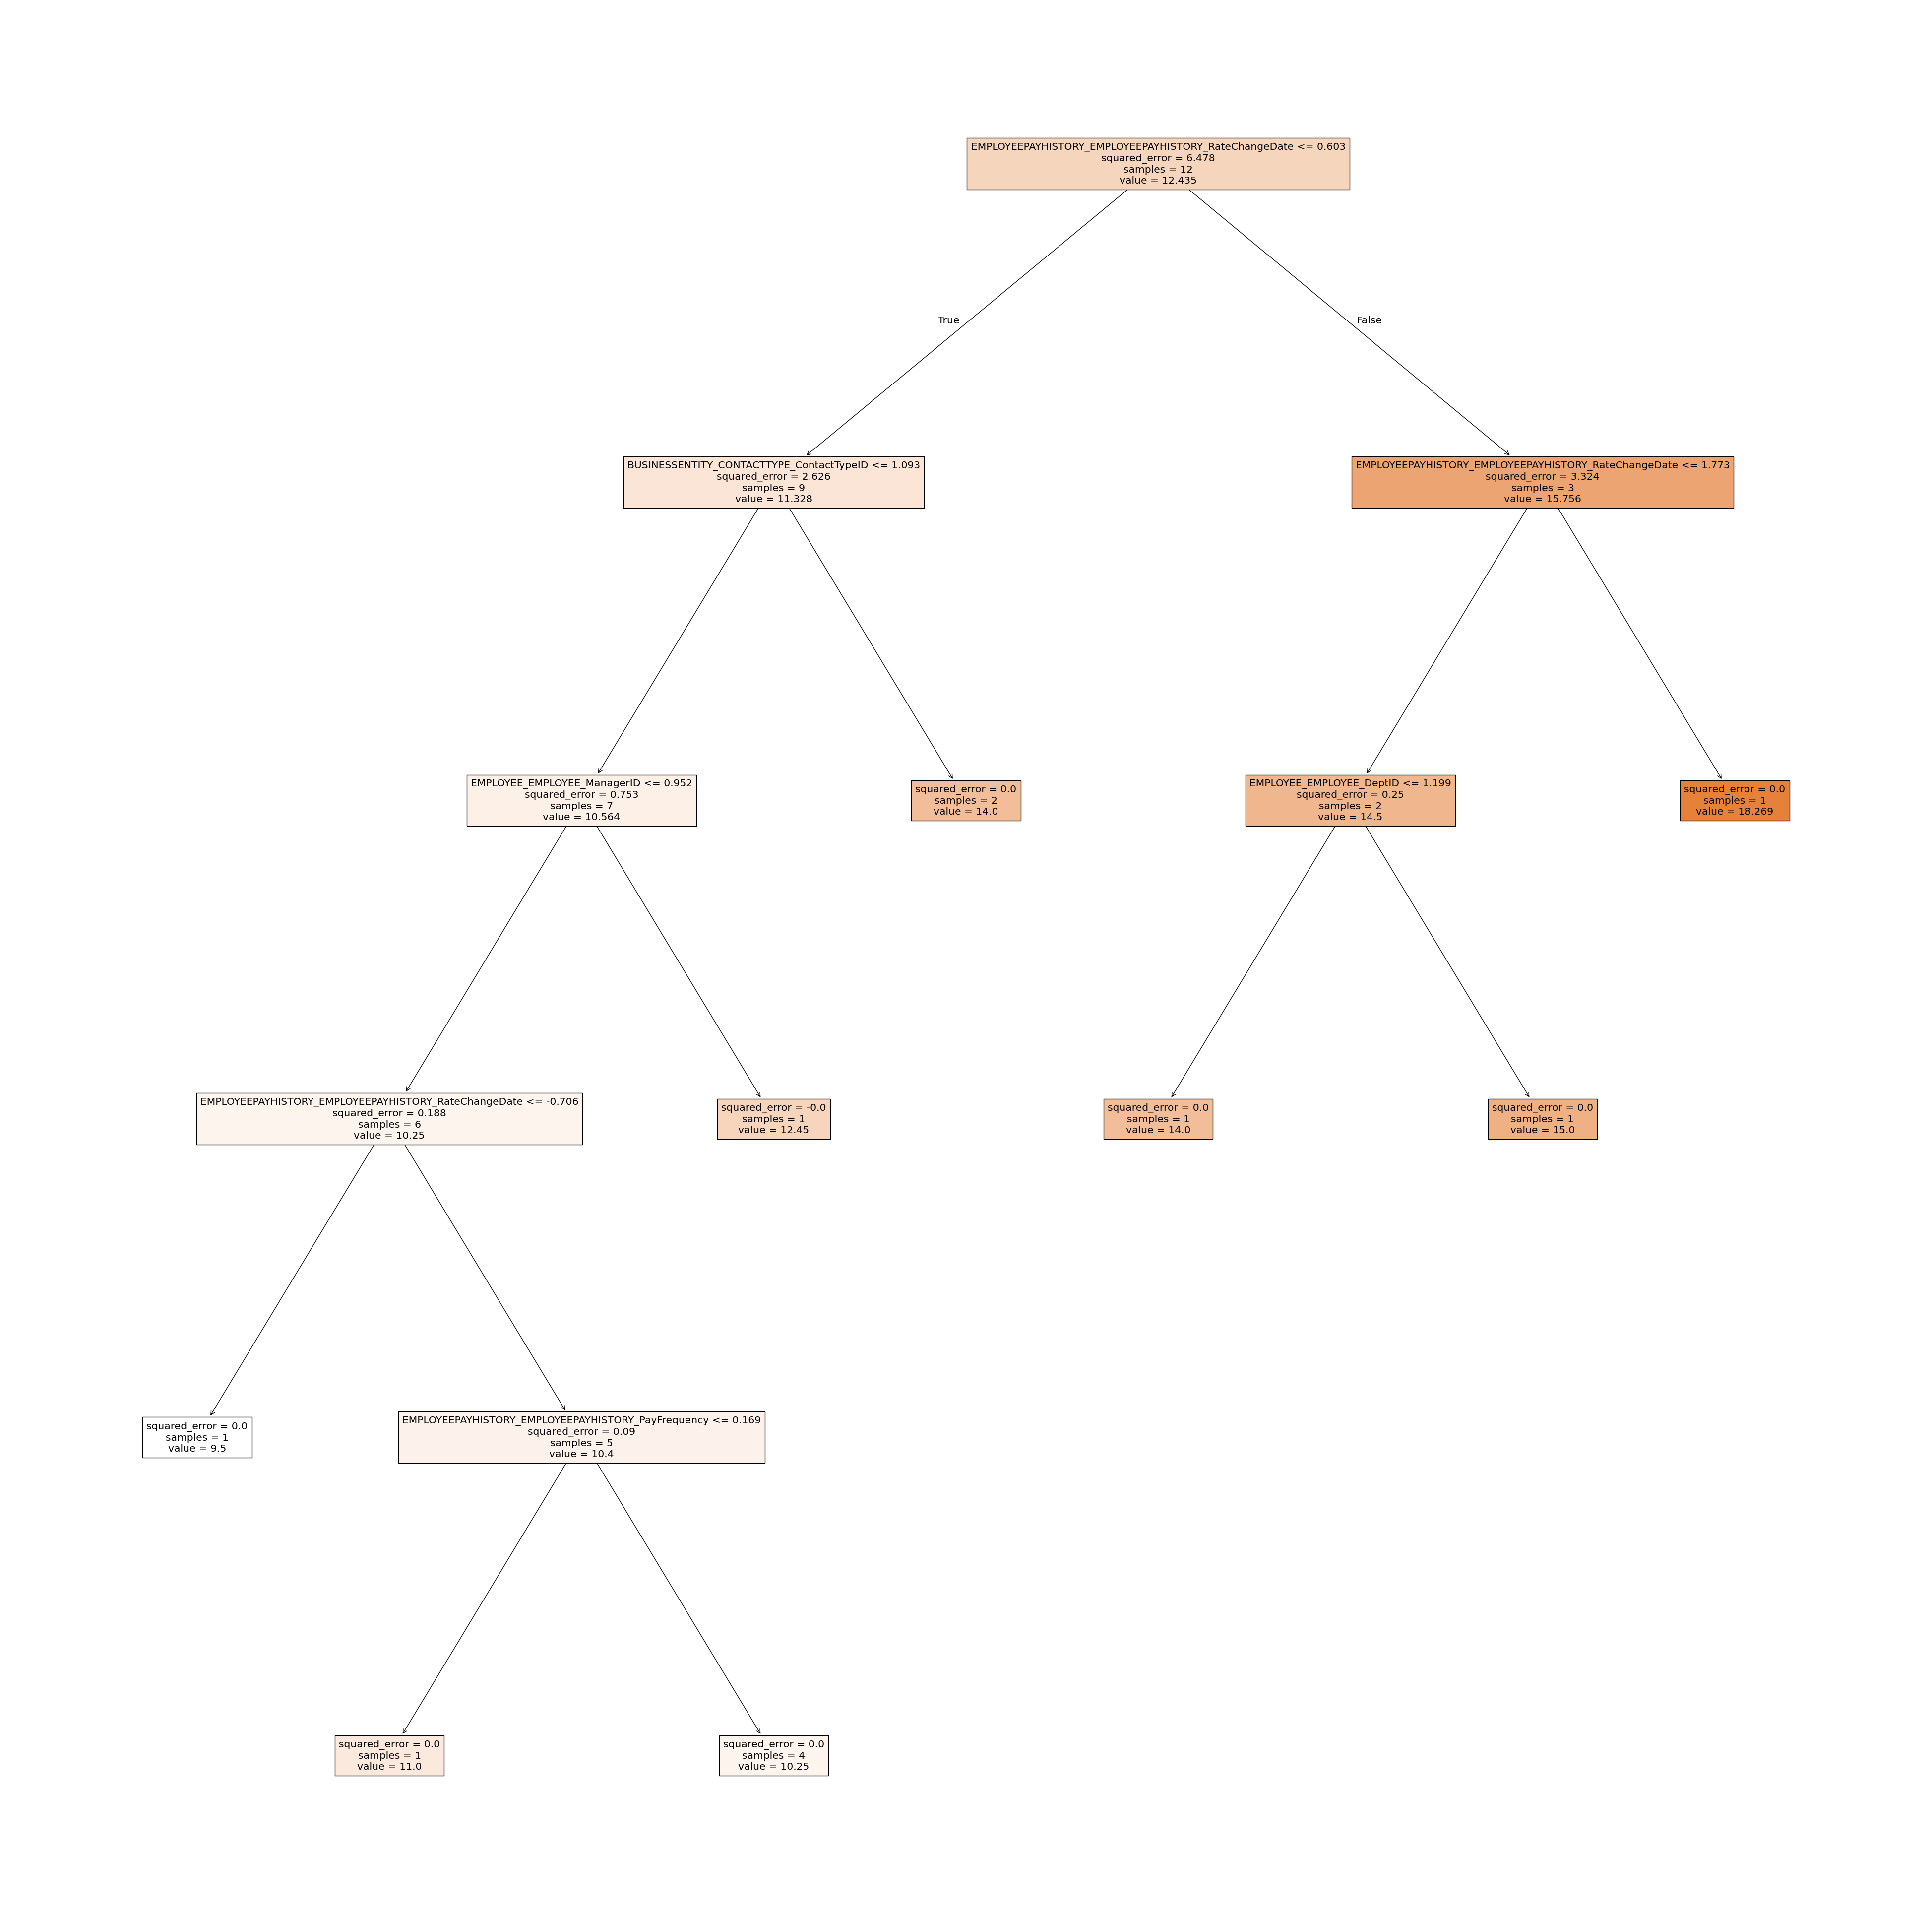

In [43]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [44]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,40.8654,10.25,30.6154,30.6154,937.302717
1,12.4500,11.00,1.4500,1.4500,2.102500
5,14.0000,14.00,0.0000,0.0000,0.000000
14,18.2692,9.50,8.7692,8.7692,76.898869


### Pytorch Neural Network

In [45]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [46]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=300)

Epoch 0, Loss: 537835.5
Epoch 100, Loss: 23.407079696655273
Epoch 200, Loss: 16.666187286376953


#### Calculating the metrics and visualizing the results

In [47]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 410.443359375
Average R2 Score: -2.135751962661743


In [48]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,40.865398,3.537950,37.327450,37.327450,1393.338501
1,12.450000,0.885103,11.564898,11.564898,133.746857
2,14.000000,18.535295,-4.535295,4.535295,20.568905
3,18.269199,8.567689,9.701510,9.701510,94.119301
